# KATECH Dataset 
This dataset includes images extracted from a video that are taken by front cameras on driving vehicles

* Bus: YYMMDD_hhmmss_I1 (2016~2017)
* HD front cam: 2012MMDD_hhmmss / Bright_~.jpg (2012~2013)
* Heptacam Project: FHD 3 cameras in front of cars (2020)

## Format
### Directory Name
* YYYYMMDD_hhmmss
* -> CameraNum
* -> CameraNum_annotations_v001_1 (TODO: Version Numbering?)

### Images
* Sampling rate: 30frame
* CameraNum_YYYYMMDD_hhmmss_FrameNum
* (eg) 2_20190821_171139_0_.jpg
    * 2_ : (CameraNum) 3 channels (1_:narrow(30 degree), 2_:mid(60 degree), 3_:wide(120 degree))
    * 20190821_ : 2019-08-21
    * 171139_ : 17:11:39
    * 0 : FrameNum

## Data Processing

### 1. Pytorch Dataset Class
* `class KATECHDetection(torch.utils.data.Dataset)`
    * Parsing dataset root directory applying above rules
    * Making a metadata of each datapoint (=canonical datapoint)
    * Saving the metadata as a file
    * Saving the metadata on a database (TODO)

In [1]:
from src.katech import KATECHDetection
import json
import os
from src.utils import draw_patches
import numpy as np
from PIL import Image
%matplotlib inline

Following checkpoint was made by parsing data directory from zero-base

In [2]:
katech = KATECHDetection.load('katech_ckpt1.pkl')

There is an annotation problem.   
The proto-type version of dataset (2020) has less kinds of categories in the annotation files.   
Also, python-None type labels were annotated in the annotation file.   
It is not only a taxonomic problem but also a consistency problem.   

In [3]:
lblmap = katech.label_name_map
del lblmap[None]
sorted(lblmap)

['Lane_Blue_Solid',
 'Lane_White_Dash',
 'Lane_White_Solid',
 'Lane_Yellow_Solid',
 'Pedestrian_Bicycle',
 'Pedestrian_Pedestrian',
 'RoadMarkArrow_Else',
 'RoadMarkArrow_Left',
 'RoadMarkArrow_Right',
 'RoadMarkArrow_Straight',
 'RoadMarkArrow_StraightLeft',
 'RoadMarkArrow_StraightRight',
 'RoadMarkArrow_Uturn',
 'RoadMark_Character',
 'RoadMark_Crosswalk',
 'RoadMark_Number',
 'RoadMark_StopLine',
 'TrafficLight_Arrow',
 'TrafficLight_Green',
 'TrafficLight_GreenArrow',
 'TrafficLight_Red',
 'TrafficLight_RedArrow',
 'TrafficLight_Yellow',
 'TrafficLight_YellowArrow',
 'TrafficSign_Else',
 'TrafficSign_Speed',
 'Vehicle_Bus',
 'Vehicle_Car',
 'Vehicle_Motorcycle',
 'Vehicle_Unknown']

In [4]:
nonelist = []
for k,v in katech.images.items():
    for lbl in v[3]:
        if lbl==None:
            nonelist.append((k,v))


In [5]:
nonelist

[(3688,
  ('/lab_shared/datasets/KATECH/KATECH2021/20200717_100230/2/2_20200717_100230_000420.jpg',
   (1920, 1080),
   [(0.6083333333333333,
     0.5574074074074075,
     0.6442708333333333,
     0.5777777777777777),
    (0.7739583333333333, 0.5824074074074074, 0.8765625, 0.6212962962962963),
    (0.27708333333333335, 0.47685185185185186, 0.328125, 0.5361111111111111),
    (0.47708333333333336,
     0.4935185185185185,
     0.5145833333333333,
     0.5444444444444444),
    (0.5135416666666667,
     0.5009259259259259,
     0.5348958333333333,
     0.5231481481481481),
    (0.9072916666666667, 0.5981481481481481, 0.996875, 0.6148148148148148),
    (0.7057291666666666, 0.40925925925925927, 0.9125, 0.6064814814814815),
    (0.3854166666666667,
     0.6166666666666667,
     0.3854166666666667,
     0.6166666666666667)],
   ['RoadMarkArrow_Straight',
    'RoadMarkArrow_Else',
    'Vehicle_Unknown',
    'Vehicle_Car',
    'Vehicle_Car',
    'RoadMarkArrow_Else',
    'Vehicle_Unknown',
    N

The None type objects were derived from nameless object in the xml annotation files. `<name></name>`   
Proto version of dataset has only one nameless object in `20190821_151252/1/1_20190821_151252_1320.jpg`

In [6]:
for idx in [x[0] for x in nonelist]:
    for i in range(len(katech.images[idx][3])):

        if katech.images[idx][3][i] == None:
            katech.images[idx][3][i] = 'None'

This is the first version of a label system in this dataset considering the alphabetical order.   
This information will be embedded in the data processing codes for a while.   
It should be registered as a table on a database for continuous management.

In [13]:
DEFAULT_LABEL_NAMES=[
        'background',
        'Lane_Blue_Solid',
        'Lane_White_Dash',
        'Lane_White_Solid',
        'Lane_Yellow_Solid',
        'Pedestrian_Bicycle',
        'Pedestrian_Pedestrian',
        'RoadMark_Character',
        'RoadMark_Crosswalk',
        'RoadMark_Number',
        'RoadMark_StopLine',
        'RoadMarkArrow_Else',
        'RoadMarkArrow_Left',
        'RoadMarkArrow_Right',
        'RoadMarkArrow_Straight',
        'RoadMarkArrow_StraightLeft',
        'RoadMarkArrow_StraightRight',
        'RoadMarkArrow_Uturn',
        'TrafficLight_Arrow',
        'TrafficLight_Green',
        'TrafficLight_GreenArrow',
        'TrafficLight_Red',
        'TrafficLight_RedArrow',
        'TrafficLight_Yellow',
        'TrafficLight_YellowArrow',
        'TrafficSign_Else',
        'TrafficSign_Speed',
        'Vehicle',
        'Vehicle_Bus',
        'Vehicle_Car',
        'Vehicle_Motorcycle',
        'Vehicle_Unknown',
        'None',
]
# DLN_SORTED = sorted(DEFAULT_LABEL_NAMES)
DEFAULT_LABEL_NAME_MAP={k:DEFAULT_LABEL_NAMES.index(k) for k in DEFAULT_LABEL_NAMES}
DEFAULT_LABEL_NAME_MAP

{'background': 0,
 'Lane_Blue_Solid': 1,
 'Lane_White_Dash': 2,
 'Lane_White_Solid': 3,
 'Lane_Yellow_Solid': 4,
 'Pedestrian_Bicycle': 5,
 'Pedestrian_Pedestrian': 6,
 'RoadMark_Character': 7,
 'RoadMark_Crosswalk': 8,
 'RoadMark_Number': 9,
 'RoadMark_StopLine': 10,
 'RoadMarkArrow_Else': 11,
 'RoadMarkArrow_Left': 12,
 'RoadMarkArrow_Right': 13,
 'RoadMarkArrow_Straight': 14,
 'RoadMarkArrow_StraightLeft': 15,
 'RoadMarkArrow_StraightRight': 16,
 'RoadMarkArrow_Uturn': 17,
 'TrafficLight_Arrow': 18,
 'TrafficLight_Green': 19,
 'TrafficLight_GreenArrow': 20,
 'TrafficLight_Red': 21,
 'TrafficLight_RedArrow': 22,
 'TrafficLight_Yellow': 23,
 'TrafficLight_YellowArrow': 24,
 'TrafficSign_Else': 25,
 'TrafficSign_Speed': 26,
 'Vehicle': 27,
 'Vehicle_Bus': 28,
 'Vehicle_Car': 29,
 'Vehicle_Motorcycle': 30,
 'Vehicle_Unknown': 31,
 'None': 32}

In [14]:
katech.label_name_map = DEFAULT_LABEL_NAME_MAP
katech.label_info = {v:k for k, v in katech.label_name_map.items()}
katech.label_info

{0: 'background',
 1: 'Lane_Blue_Solid',
 2: 'Lane_White_Dash',
 3: 'Lane_White_Solid',
 4: 'Lane_Yellow_Solid',
 5: 'Pedestrian_Bicycle',
 6: 'Pedestrian_Pedestrian',
 7: 'RoadMark_Character',
 8: 'RoadMark_Crosswalk',
 9: 'RoadMark_Number',
 10: 'RoadMark_StopLine',
 11: 'RoadMarkArrow_Else',
 12: 'RoadMarkArrow_Left',
 13: 'RoadMarkArrow_Right',
 14: 'RoadMarkArrow_Straight',
 15: 'RoadMarkArrow_StraightLeft',
 16: 'RoadMarkArrow_StraightRight',
 17: 'RoadMarkArrow_Uturn',
 18: 'TrafficLight_Arrow',
 19: 'TrafficLight_Green',
 20: 'TrafficLight_GreenArrow',
 21: 'TrafficLight_Red',
 22: 'TrafficLight_RedArrow',
 23: 'TrafficLight_Yellow',
 24: 'TrafficLight_YellowArrow',
 25: 'TrafficSign_Else',
 26: 'TrafficSign_Speed',
 27: 'Vehicle',
 28: 'Vehicle_Bus',
 29: 'Vehicle_Car',
 30: 'Vehicle_Motorcycle',
 31: 'Vehicle_Unknown',
 32: 'None'}

Applying the initial label system, a conversion of the annotation file format to coco-style will be conducted. (commented for avoiding redundant operations)

In [27]:
# katech.to_coco('instances_all2021.json')

In [37]:
# katech.set_val()
# katech.to_coco('instances_val2021.json')
# katech.set_train()
# katech.to_coco('instances_train2021.json')

In [15]:
katech_all = 'instances_all2021.json'
with open(katech_all) as f:
    katech_all_dict = json.load(f)
label_map = {a['id']:a['name'] for a in katech_all_dict['categories']}
image_map = {a['id']:a['file_name'] for a in katech_all_dict['images']}

This normalized Dataset information is stored into a new checkpoint.

In [38]:
# katech.save('katech_ckpt2.pkl')

This is examples of COCO-style annotation of this dataset.

In [16]:
katech_all_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [17]:
 katech_all_dict['info']

{'description': 'KATECH Dataset 2021',
 'url': 'n.a.',
 'version': '0.1',
 'year': 2021,
 'contributor': 'ROK MOTIE Autonomous Vehicle Consortium',
 'date_created': '2021/04/22'}

In [60]:
katech_all_dict['images'][0]

{'license': 1,
 'file_name': 'Bright_20120730_103708_000000.jpg',
 'coco_url': 'n.a.',
 'height': 672,
 'width': 1280,
 'flickr_url': 'n.a.',
 'id': 0}

In [19]:
katech_all_dict['annotations'][0]

{'iscrowd': 0,
 'image_id': 0,
 'area': 245753.99999999994,
 'bbox': [492.0, 555.0, 691.0, 55.0],
 'category_id': 10,
 'id': 0}

### 2. Simple Exploration of the Dataset
* Annotation filter by 
    * object category
    * object size   
    
Let's look through a Pedestrian_Bicycle category

In [20]:
def annotations_filter(filter_key: 'category id', size_th = 10000):
    return [item for item in katech_all_dict['annotations'] 
            if item['category_id']==filter_key and 
            item['bbox'][3]*item['bbox'][2] > size_th]

In [21]:
pd_bicycle = annotations_filter(5)
len(pd_bicycle)

885

In [22]:
from tqdm import tqdm

`KATECHDetection.get_patch()` function takes an object information and returns an original image and the object image patch.   
You can save this image patches by each category for an exploration. It takes some time because of my brute-force file loading implementation.

In [23]:
savedir = '/home/dklee/tmp/patch_test'
# for i in range():
# save_subdir = os.path.join(savedir, str(i)) 
cname = katech.label_info[5] #pd_bicycle
print(cname)

for obj in tqdm(pd_bicycle):
    _, patch = katech.get_patch(obj)
    fn = '_'.join([image_map[obj['image_id']][:-4], str(obj['id'])]) + '.png'
    with open(os.path.join(savedir,fn), 'wb') as f:
        patch.save(f)
#     cnt += 1



  0%|          | 3/885 [00:00<00:36, 24.27it/s]

Pedestrian_Bicycle


100%|██████████| 885/885 [01:05<00:00, 13.44it/s]


In [49]:
_, patch = katech.get_patch(obj) # the last 

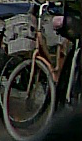

In [51]:
patch

In [24]:
# for i in range (7,30):
#     os.mkdir('/home/dklee/data/KATECH/patch/' + str(i))

In [61]:
# from IPython.display import HTML, Image
# def _src_from_data(data):
#     """Base64 encodes image bytes for inclusion in an HTML img element"""
#     img_obj = Image(data=data)
#     for bundle in img_obj._repr_mimebundle_():
#         for mimetype, b64value in bundle.items():
#             if mimetype.startswith('image/'):
#                 return f'data:{mimetype};base64,{b64value}'

# def gallery(images, row_height='auto'):
#     """Shows a set of images in a gallery that flexes with the width of the notebook.
    
#     Parameters
#     ----------
#     images: list of str or bytes
#         URLs or bytes of images to display

#     row_height: str
#         CSS height value to assign to all images. Set to 'auto' by default to show images
#         with their native dimensions. Set to a value like '250px' to make all rows
#         in the gallery equal height.
#     """
#     figures = []
#     for image in images:
#         if isinstance(image, bytes):
#             src = _src_from_data(image)
#             caption = ''
#         else:
#             src = image
#             caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
#         figures.append(f'''
#             <figure style="margin: 5px !important;">
#               <img src="{src}" style="height: {row_height}">
#               {caption}
#             </figure>
#         ''')
#     return HTML(data=f'''
#         <div style="display: flex; flex-flow: row wrap; text-align: center;">
#         {''.join(figures)}
#         </div>
#     ''')

In [66]:
# import io

# pngs = []
# for img in patches:
#     buffer = io.BytesIO()
#     img.save(buffer, 'png')
#     pngs.append(buffer.getvalue())

### 3. Distributions of the Dataset
Train and validation were created linearly separating the all data points. This is a simple looking for a distribution according to the 'year'


In [25]:
katech_train = 'instances_train2021.json'
with open(katech_train) as f:
    katech_train_dict = json.load(f)
katech_val = 'instances_val2021.json'
with open(katech_val) as f:
    katech_val_dict = json.load(f)


In [26]:
from collections import defaultdict
def extract_year(fn):
    yyyymmdd = fn.split('_')[1]
    return int(yyyymmdd[:4])

In [43]:
years_train = defaultdict(int)
for img in katech_train_dict['images']:
    year = extract_year(img['file_name'])
    years_train[year] += 1

In [44]:
years = [x[0] for x in sorted(years_train.items())]
cnt_train = [x[1] for x in sorted(years_train.items())]

In [45]:
years_val = defaultdict(int)
for img in katech_val_dict['images']:
    year = extract_year(img['file_name'])
    years_val[year]+=1

In [52]:
for k, v in years_train.items():
    print(years_val[k])

1370
7209
3677
0
27


In [67]:
print(years_train)
print(years_val)

defaultdict(<class 'int'>, {2012: 20497, 2020: 69105, 2013: 20603, 2017: 128, 2016: 209})
defaultdict(<class 'int'>, {2012: 1370, 2013: 3677, 2020: 7209, 2016: 27, 2017: 0})


In [81]:
sorted(os.listdir('/lab_shared/datasets/KATECH/KATECH2021/20130217_152841'))

['Bright', 'Bright_annotations_v001_1']

In [24]:
import matplotlib.pyplot as plt

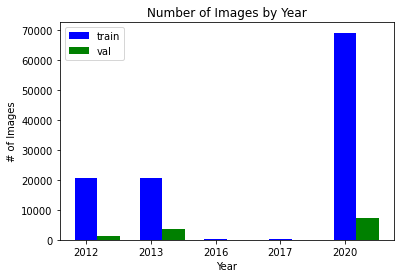

In [69]:
n_groups = len(years)
cnt_train = [x[1] for x in sorted(years_train.items())]
cnt_val = [x[1] for x in sorted(years_val.items())]
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
rects1 = plt.bar(index, cnt_train, bar_width, alpha=opacity, color='b', label='train')
rects2 = plt.bar(index+bar_width, cnt_val, bar_width, alpha=opacity, color='g', label='val')

plt.xlabel('Year')
plt.ylabel('# of Images')
plt.title('Number of Images by Year')
plt.xticks(index, years)
plt.legend()
plt.show()

## Data Exploration, Evaluation, and Management